In [1]:
%load_ext autoreload
%autoreload 2

# Necessary imports
import os
import sys
import warnings

import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

sys.path.append('../..')
from seismiqb.batchflow import Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, D, P, R, W, L
from seismiqb.batchflow.models.torch.layers import *
from seismiqb.batchflow.models.torch import *

from seismiqb import SeismicCubeset, SeismicGeometry
from seismiqb import plot_image, plot_loss

from utils import show_slide_dataset, show_slide

# Set GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# Global parameters
CROP_SHAPE = (1, 512, 832)       # shape of sampled 3D crops
DYNAMIC_FACTOR = 1.              # scaling of shape during train
ITERS = 800                      # number of train iterations
BATCH_SIZE = 512                 # number of crops inside one batch


CLASS_LABELS = [
    'Basement/other',
    'Slope Mudstone A',
    'Mass Transport\n Deposit',
    'Slope Mudstone B',
    'Slope Valley',
    'Submarine Canyon\n System'
]

# Dataset

In [3]:
cube_path = '/data/hackathon/train_amplitudes.hdf5'
label_path = '/data/hackathon/train_labels.hdf5'

dsi = FilesIndex(path=[cube_path], no_ext=True)
dataset = SeismicCubeset(dsi)

dataset.load_geometries()
dataset.labels[dataset.indices[0]] = SeismicGeometry(label_path)

print(dataset.geometries[0])


Geometry for cube              /data/hackathon/train_amplitudes.hdf5
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Shape:                         [ 590  782 1006]
Time delay and sample rate:    0, 0

Cube size:                     5.29 GB
Size of the instance:          0.0111 GB

Number of traces:              461380
Number of non-zero traces:     461380

Num of unique amplitudes:      1000374
Mean/std of amplitudes:        0.651106/389.008
Min/max amplitudes:            -5195.52/5151.72
q01/q99 amplitudes:            -1064.14/1077.37



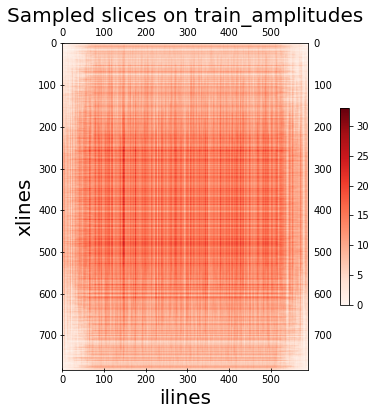

In [4]:
dataset.create_sampler(mode='default')
dataset.modify_sampler('train_sampler', finish=True)

_ = dataset.show_slices(src_sampler='train_sampler',
                        normalize=False, shape=CROP_SHAPE, side_view=True,                        
                        cmap='Reds', interpolation='bilinear',
                        figsize=(8, 6))

# Data showcase

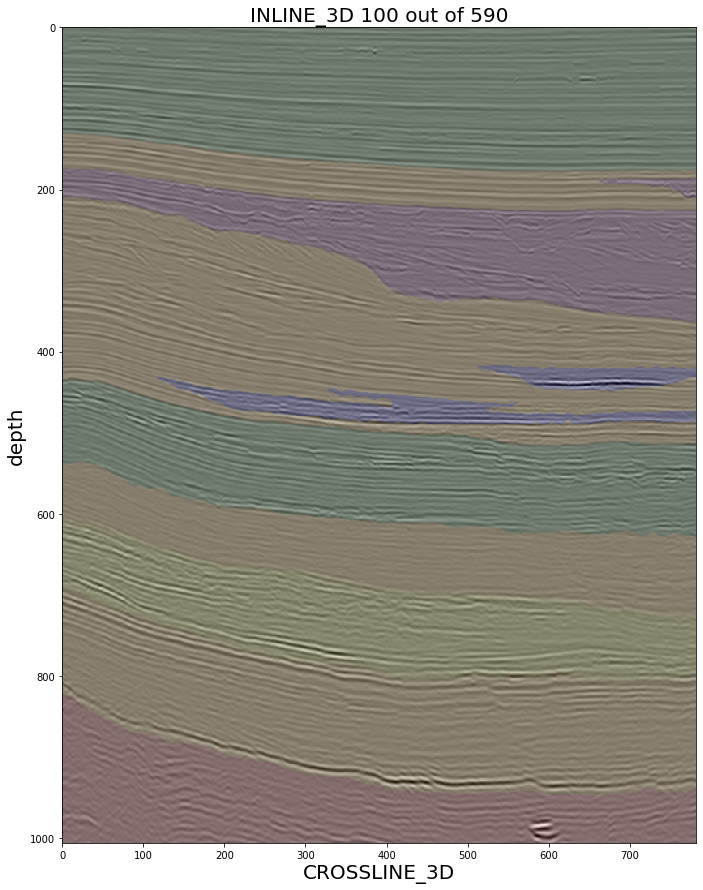

In [5]:
show_slide_dataset(100, dataset=dataset, figsize=(15, 15))

# Model

In [6]:
import torch

def dice_loss(pred, target, eps=1e-7):
    num_classes = pred.shape[1]
    target = target.long()
    
    probas = torch.nn.functional.softmax(pred, dim=1)

    true_1_hot = torch.eye(num_classes)[target.squeeze(1)]
    true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
    

    true_1_hot = true_1_hot.to(pred.device).type(pred.type())
    dims = (0,) + tuple(range(2, target.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    loss = (2. * intersection / (cardinality + eps)).mean()
    return 1 - loss

In [7]:
MODEL_CONFIG = {
    'inputs/masks/classes': 6,

    # Model layout
    'initial_block': {
        'base_block': ResBlock,
        'filters': 16,
        'kernel_size': 5,
        'downsample': False,
        'attention': 'scse'
    },

    'body/encoder': {
        'num_stages': 4,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': [32, 64, 128, 256],
            'attention': 'scse',
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': 256,
        'attention': 'scse',
    },
    'body/decoder': {
        'num_stages': 4,
        'upsample': {
            'layout': 'tna',
            'kernel_size': 2,
        },
        'blocks': {
            'base': ResBlock,
            'filters': [128, 64, 32, 16],
            'attention': 'scse',
        },
    },
    'head': {
        'base_block': ResBlock,
        'filters': [16, 8],
        'attention': 'scse'
    },
    'output': 'sigmoid',
    # Train configuration
    'loss': dice_loss,
    'optimizer': {'name': 'Adam', 'lr': 0.01,},
    'decay': {'name': 'exp', 'gamma': 0.5, 'frequency': 100},
    'microbatch': 2,
    'common/activation': 'relu6',
}

In [8]:
def generate_shape(batch, shape, dynamic_factor=1, dynamic_low=None, dynamic_high=None):
    dynamic_low = dynamic_low or dynamic_factor
    dynamic_high = dynamic_high or dynamic_factor

    i, x, h = shape
    x_ = np.random.randint(x // dynamic_low, x * dynamic_high + 1)
    h_ = np.random.randint(h // dynamic_low, h * dynamic_high + 1)
    return (i, x_, h_)

def adjust_masks(batch):
    batch.masks -= 1
    batch.masks = batch.masks.astype(np.float32)

In [9]:
train_template = (
    Pipeline()
    # Initialize pipeline variables and model
    .init_variable('loss_history', [])
    .init_model('dynamic', EncoderDecoder, 'model', MODEL_CONFIG)

    # Dynamically generate shape
    .init_variable('shape', None)
    .call(generate_shape, shape=C('crop_shape'),
          dynamic_factor=DYNAMIC_FACTOR, save_to=V('shape'))
    .crop(points=D('train_sampler')(BATCH_SIZE),
          shape=V('shape'))
    
    # Load data/masks
    .load_cubes(dst='images')
    .load_cubes(dst='masks', src_geometry='labels')
    .adaptive_reshape(src=['images', 'masks'], shape=V('shape'))
    .scale(mode='q', src='images')
    .call(adjust_masks)
    
    # Augmentations
    .transpose(src=['images', 'masks'], order=(1, 2, 0))
    .additive_noise(scale=0.005, src='images', dst='images', p=0.3)
    .flip(axis=1, src=['images', 'masks'],
          seed=P(R('uniform', 0, 1)), p=0.3)
    .rotate(angle=P(R('uniform', -15, 15)),
            src=['images', 'masks'], p=0.3)
    .scale_2d(scale=P(R('uniform', 0.85, 1.15)),
              src=['images', 'masks'], p=0.3)
    .elastic_transform(alpha=P(R('uniform', 35, 45)),
                       sigma=P(R('uniform', 4, 4.5)),
                       src=['images', 'masks'], p=0.2)
    .transpose(src=['images', 'masks'], order=(2, 0, 1))

    # Training
    .train_model('model',
                 fetches='loss',
                 images=B('images'),
                 masks=B('masks'),
                 save_to=V('loss_history', mode='a'))
)

ppl_config = {'crop_shape': CROP_SHAPE}
train_pipeline = (train_template << ppl_config)  << dataset

In [10]:
%%time
batch = train_pipeline.next_batch(1)

CPU times: user 2min 45s, sys: 25.7 s, total: 3min 11s
Wall time: 3min 9s


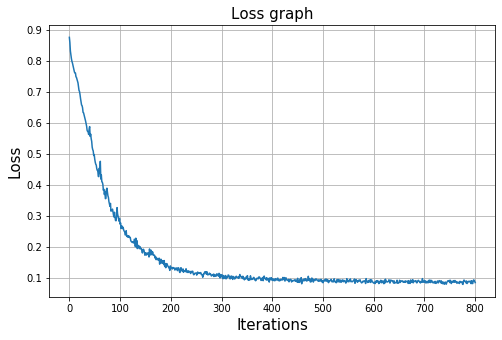

CPU times: user 1d 12h 48min 57s, sys: 4h 32min 3s, total: 1d 17h 21min
Wall time: 15h 24min 31s


In [11]:
%%time
train_pipeline.run(D('size'), n_iters=ITERS,
                   bar={'bar': 'n', 'monitors': 'loss_history'})

plot_loss(train_pipeline.v('loss_history'))

In [12]:
train_pipeline.reset('variables')
torch.cuda.empty_cache()

# Batch validation

In [13]:
# Validation pipeline: no augmentations
val_template = (
    Pipeline()
    # Import model
    .import_model('model', train_pipeline)

    # Load data/masks
    .crop(points=D('train_sampler')(16), shape=CROP_SHAPE)
    .load_cubes(dst='images')
    .load_cubes(dst='masks', src_geometry='labels')
    .scale(mode='q', src='images')
    .call(adjust_masks)

    # Predict with model
    .predict_model('model',
                   B('images'),
                   fetches='predictions',
                   save_to=B('predictions'))
    .transpose(src=['images', 'masks', 'predictions'],
               order=(1, 2, 0))
)
val_pipeline = val_template << dataset

In [14]:
%%time
batch = val_pipeline.next_batch(1)

CPU times: user 500 ms, sys: 985 ms, total: 1.49 s
Wall time: 36.1 s


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(batch.masks.flatten(),
                      np.argmax(batch.predictions, axis=-1).flatten())

report = classification_report(batch.masks.flatten(),
                               np.argmax(batch.predictions, axis=-1).flatten())
print(report)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99    446074
         1.0       0.97      0.98      0.98   3333118
         2.0       0.96      0.96      0.96    507439
         3.0       0.99      0.99      0.99   1758939
         4.0       0.94      0.90      0.92    119951
         5.0       0.97      0.96      0.97    650223

    accuracy                           0.98   6815744
   macro avg       0.97      0.96      0.97   6815744
weighted avg       0.98      0.98      0.98   6815744



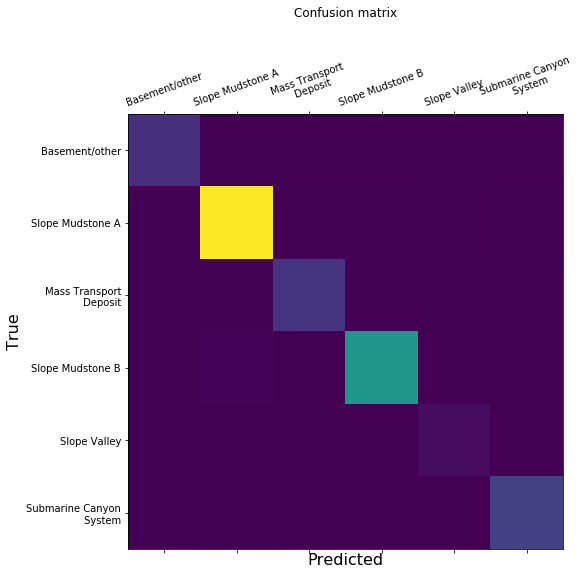

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.matshow(cm)

plt.title('Confusion matrix', y=1.21)
plt.xticks(rotation=20)
ax.set_xticklabels([''] + CLASS_LABELS)
ax.set_yticklabels([''] + CLASS_LABELS)

plt.xlabel('Predicted', fontdict={'fontsize': 16})
plt.ylabel('True', fontdict={'fontsize': 16})
plt.show()

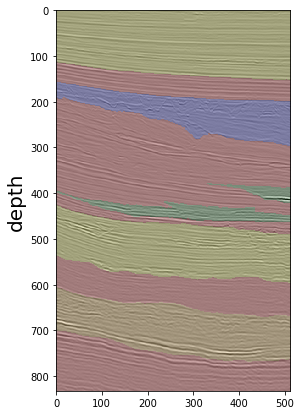

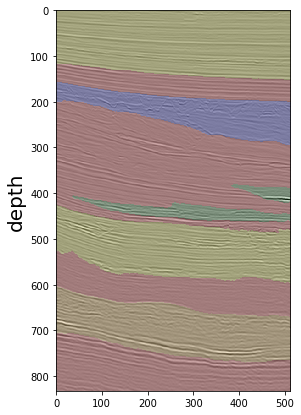

In [17]:
idx = 4
img, mask, pred = batch.images[idx], batch.masks[idx], batch.predictions[idx]

show_slide((img, mask), opacity=0.15)
show_slide((img, np.argmax(pred, axis=-1)), opacity=0.15)

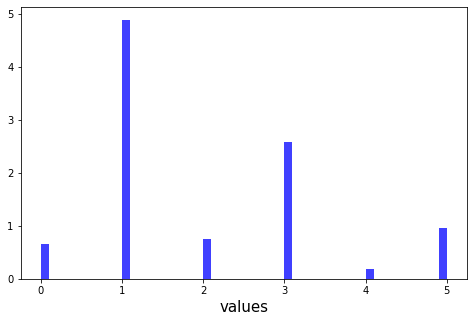

In [18]:
plot_image(batch.masks, mode='histogram')

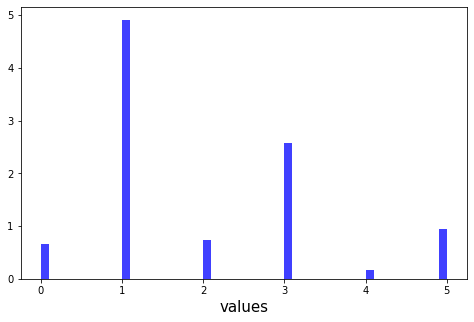

In [19]:
plot_image(np.argmax(batch.predictions, axis=-1), mode='histogram')

In [ ]:
train_pipeline.save_model_now('model', '/data/hackathon/MODELS/baseline')

# Inference

In [20]:
test_path = '/data/hackathon/test_amplitudes.hdf5'

dsi = FilesIndex(path=[test_path], no_ext=True)
test_dataset = SeismicCubeset(dsi)

test_dataset.load_geometries()

geometry = test_dataset.geometries[0]
print(geometry)


Geometry for cube              /data/hackathon/test_amplitudes.hdf5
Current index:                 ['INLINE_3D', 'CROSSLINE_3D']
Shape:                         [ 251  782 1006]
Time delay and sample rate:    0, 0

Cube size:                     2.26 GB
Size of the instance:          0.00912 GB

Number of traces:              196282
Number of non-zero traces:     196282

Num of unique amplitudes:      1008338
Mean/std of amplitudes:        0.229655/362.857
Min/max amplitudes:            -4723.01/5247.89
q01/q99 amplitudes:            -1088.14/1053.14



In [21]:
inference_template = (
    Pipeline()
    # Initialize everything
    .init_variable('result_preds', [])
    .import_model('model', train_pipeline)

    # Load data
    .crop(points=D('grid_gen')(),
          shape=CROP_SHAPE)
    .load_cubes(dst='images')
    .adaptive_reshape(src='images', shape=CROP_SHAPE)
    .scale(mode='q', src='images')

    # Predict with model, then aggregate
    .predict_model('model',
                   B('images'),
                   fetches='predictions',
                   save_to=V('result_preds', mode='e'))
)

In [22]:
test_dataset.make_grid(test_dataset.indices[0], CROP_SHAPE,
                       [0, 251], [0, 782], [0, 1006],
                       overlap=(1, 128, 128),
                       batch_size=16)

inference_pipeline = inference_template << test_dataset
inference_pipeline.run(D('size'), n_iters=test_dataset.grid_iters, bar='n')

In [23]:
lst = [np.argmax(item, axis=0)[np.newaxis, :, :] for item in inference_pipeline.v('result_preds')]

assembled_pred = test_dataset.assemble_crops(lst, order=(0, 1, 2))
assembled_pred.shape

(251, 782, 1006)

# To NPZ

In [24]:
def convert_hdf5_to_npz(data, path_npz, name='prediction', order=(2, 1, 0)):
    if isinstance(data, str):
        geometry = SeismicGeometry(path_hdf5)
        data = geometry.file_hdf5['cube'].value

    np.savez_compressed(path_npz, **{name: np.transpose(data, order)})

In [25]:
path_save = '/data/hackathon/PREDICTIONS/baseline.npz'
convert_hdf5_to_npz(assembled_pred+1, path_save)